# Deepmind TurnerLab (Pillar IV) Dataset 06-07-2023

**Data Source:** *16FlYMaze System, Turner Lab, HHMI Janelia Research Campus*

**Collected By:** *Kaitlyn Boone, Aparna Dev, PTR, HHMI Janelia Research Campus*

**Code Author:** *Rishika Mohanta*


In [1]:
# LIBRARY IMPORTS

# import libraries
import numpy as np                      # for numerical operations
import pandas as pd                     # for data manipulation
import matplotlib.pyplot as plt         # for plotting
import scipy.optimize as opt            # for optimization
from joblib import Parallel, delayed    # for parallelization
from tqdm.notebook import tqdm          # for progress bar
import pickle                           # for saving and loading
import os                               # for file operations
import gzip                             # for compressing files 
import torch                            # for neural networks
import torch.nn as nn                   # for neural networks
import torch.nn.functional as F         # for neural networks
from torch.utils.data import TensorDataset, DataLoader # for neural networks
import copy                             # for copying objects

# import statistics modules
from scipy.stats import wilcoxon       # for wilcoxon signed-rank test
from sklearn.cluster import AgglomerativeClustering # for clustering

# import cognitive models
from pygorl.cogpolicy import *     # Cognitive Policy Learning models
from pygorl.cogq import *          # Cognitive Q-learning models

# import sklearn modules
from sklearn.linear_model import LogisticRegression # for logistic regression

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
data_path = '../data/dmData_14-09-2023/' # path to data files
fit_path = '../processed_data/dmData_06-07-2023/' # path to fitted models
quality_control = 'full' # whether to perform quality control (valid options: minimal, full, none)
last_date = '2024-06-10 00:00:00' # last date of data collection
recalculate = True # whether to recalculate all data (True) or load from file (False)

In [3]:
# DATA LOADING

# load data
choice_data = np.loadtxt(data_path + 'choices.csv', delimiter=',')
reward_data = np.loadtxt(data_path + 'rewards.csv', delimiter=',')

# turn into integers
choice_data = choice_data.astype(int)
reward_data = reward_data.astype(int)

if choice_data.shape != reward_data.shape:
    raise ValueError('Sizes do not match.')

N = choice_data.shape[0]    # number of flies

print("Data loaded successfully with N = {} flies and {} maximum trials".format(N, choice_data.shape[1]))

# load metadata
metadata = pd.read_csv(data_path + 'metadata.csv')
metadata['Experiment Start Time'] = pd.to_datetime(metadata['Experiment Start Time'], format='%Y-%m-%d %H:%M:%S')
metadata['Starvation Time'] = pd.to_datetime(metadata['Starvation Time'], format='%Y-%m-%d %H:%M:%S')

# load quality control data
qc = np.loadtxt(data_path + 'quality_control.csv', delimiter=',').astype(bool)

Data loaded successfully with N = 446 flies and 1318 maximum trials


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_41883/2453591249.py:8: RuntimeWarning: invalid value encountered in cast
  choice_data = choice_data.astype(int)
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_41883/2453591249.py:9: RuntimeWarning: invalid value encountered in cast
  reward_data = reward_data.astype(int)


## Check Control Experiments to make sure they are behaving normally

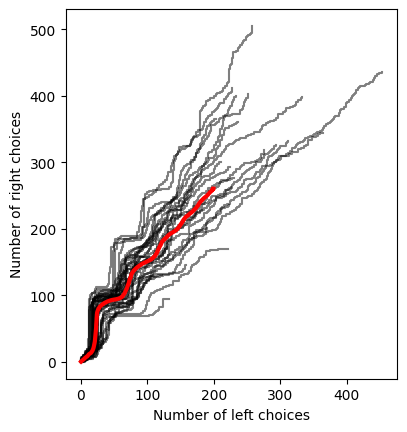

In [4]:
control_c_f = choice_data[metadata['Fly Experiment'] == 'control.csv']
control_r_f = reward_data[metadata['Fly Experiment'] == 'control.csv']
control_c_r = choice_data[metadata['Fly Experiment'] == 'control_reciprocal.csv']
control_r_r = reward_data[metadata['Fly Experiment'] == 'control_reciprocal.csv']
control_c = np.concatenate((control_c_f, 1-control_c_r), axis=0)
control_r = np.concatenate((control_r_f, control_r_r), axis=0)
trajs = []
for i in range(len(control_c)):
    c = control_c[i]
    r = control_r[i]
    # keep only 0 or 1
    valid  = (c == 0) | (c == 1)
    c = c[valid]
    r = r[valid]
    c_0 = np.cumsum(c==0)
    c_1 = np.cumsum(c==1)
    plt.plot(c_0,c_1, color='black', alpha=0.5)
    trajs.append(np.stack((c_0,c_1), axis=1))
# plot mean
max_len = max([len(t) for t in trajs])
trajs = np.stack([np.concatenate((t, np.tile(t[-1], (max_len-len(t),1))), axis=0) for t in trajs], axis=0)
plt.plot(trajs[:,:,0].mean(axis=0), trajs[:,:,1].mean(axis=0), color='red', linewidth=3)
plt.xlabel('Number of left choices')
plt.ylabel('Number of right choices')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [5]:
# remove all control flies
choice_data = choice_data[metadata['Fly Experiment'] != 'control.csv']
reward_data = reward_data[metadata['Fly Experiment'] != 'control.csv']
qc = qc[metadata['Fly Experiment'] != 'control.csv']
metadata = metadata[metadata['Fly Experiment'] != 'control.csv']
choice_data = choice_data[metadata['Fly Experiment'] != 'control_reciprocal.csv']
reward_data = reward_data[metadata['Fly Experiment'] != 'control_reciprocal.csv']
qc = qc[metadata['Fly Experiment'] != 'control_reciprocal.csv']
metadata = metadata[metadata['Fly Experiment'] != 'control_reciprocal.csv']
metadata.reset_index(drop=True, inplace=True)

In [6]:
# QUALITY CONTROL

if quality_control == 'minimal':
    choice_data = choice_data[qc]
    reward_data = reward_data[qc]
    metadata = metadata[qc]
    metadata.reset_index(drop=True, inplace=True)
if quality_control == 'full':
    metadata = metadata[qc]
    metadata = metadata[metadata['Experiment Start Time'] < last_date].groupby('Fly Experiment').head(3)
    choice_data = choice_data[metadata.index]
    reward_data = reward_data[metadata.index]
    metadata.reset_index(drop=True, inplace=True)

print("{}/{} ({}) flies passed quality control".format(choice_data.shape[0], N, "{:0.2f}".format(choice_data.shape[0]/N*100)))

N = choice_data.shape[0]    # number of flies

360/446 (80.72) flies passed quality control


### Create a minimal cleaned version of the dataset

In [7]:
# create list for storing results fly by fly
results = []

# loop over flies
for i in range(N):
    temp = {}
    temp['fly_id'] = metadata['Experiment Start Time'][i].strftime('%d%m%y_%H%M') + '_' + str(metadata['Arena'][i])
    temp['choices'] = choice_data[i]
    temp['rewards'] = reward_data[i]
    temp['n_trials'] = len(temp['choices'])
    for key in metadata.columns:
        key_ = key.lower().replace(' ', '_')
        temp[key_] = metadata[key][i]
    results.append(temp)

# save results
with gzip.open(data_path + 'cleaned_{}_data.pkl.gz'.format(quality_control), 'wb') as f:
    pickle.dump(results, f)

# save keys in a text file
with open(data_path + 'key_list.txt'.format(quality_control), 'w') as f:
    f.write('The data is a list of dictionaries, each corresponding to a fly.\n')
    f.write('Each dictionary contains the following keys:\n')
    for key in results[0].keys():
        f.write(key + '\t')

## Basic Data Analysis for Verification of Dataset Quality

### Dataset Properties

First, lets get the dataset distribution of experiments and odor identities.


In [8]:
# Experiment Distribution and Odor Identity
experiments = metadata['Fly Experiment']

n_unique_experiments = experiments.apply(lambda x: x.replace('_reciprocal', '')).unique().shape[0]
replicates_per_experiment = np.unique(experiments, return_counts=True)[1]
variations_per_experiment = experiments.unique().shape[0] / experiments.apply(lambda x: x.replace('_reciprocal', '')).unique().shape[0]
print("Dataset has {} unique experiments with ~{:0.1f} reciprocal variations each. ".format(n_unique_experiments, variations_per_experiment),end='')
print("Every experiment has {:d} ± {:.1f} flies".format(int(np.mean(replicates_per_experiment)), int(np.std(replicates_per_experiment))))

if np.unique(metadata['Odor 1']).shape[0] == 1:
    odor1 = np.unique(metadata['Odor 1'])[0]
else:
    raise ValueError('More than one odor 1.')

if np.unique(metadata['Odor 2']).shape[0] == 1:
    odor2 = np.unique(metadata['Odor 2'])[0]
else:
    raise ValueError('More than one odor 2.')

print("Odor 1 (Conc. in Paraffin) = {}".format(odor1))
print("Odor 2 (Conc. in Paraffin) = {}".format(odor2))


Dataset has 60 unique experiments with ~2.0 reciprocal variations each. Every experiment has 3 ± 0.0 flies
Odor 1 (Conc. in Paraffin) = MHO 1:1000
Odor 2 (Conc. in Paraffin) = HAL 1:1000


Lets get the starvation period for each fly and plot the distribution

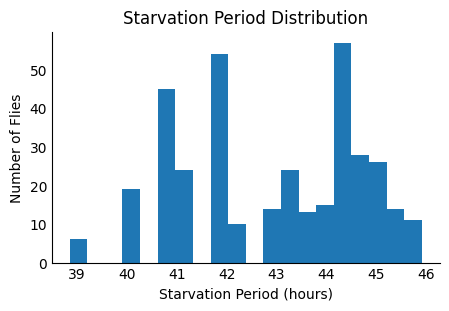

In [9]:
# Starvation Period Distribution
starvation_period = pd.to_datetime(metadata['Experiment Start Time'], format='%Y-%m-%d %H:%M:%S')-pd.to_datetime(metadata['Starvation Time'], format='%Y-%m-%d %H:%M:%S')
manual_times = metadata['Folder'].apply(lambda x: int(x.split('/')[2].split('hr')[0]))

# if starvation_period is less than 30 hours or more than 50 hours, print warning and replace with manual entry
if np.min(starvation_period.dt.total_seconds()/3600) < 30 or np.max(starvation_period.dt.total_seconds()/3600) > 50:
    print("WARNING: Starvation period is out of range for some flies. Replacing with manual entry.")
    for i in range(len(starvation_period)):
        if starvation_period[i].total_seconds()/3600 < 30 or starvation_period[i].total_seconds()/3600 > 50:
            starvation_period[i] = pd.to_timedelta(str(manual_times[i])+' hours')
    

# plot starvation period histogram
plt.figure(figsize=(5,3))
plt.hist(starvation_period.dt.total_seconds()/3600, bins=20)
plt.xlabel('Starvation Period (hours)')
plt.ylabel('Number of Flies')
plt.title('Starvation Period Distribution')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(axis='both', which='both', length=0)
plt.show()

It seems that the flies were run between a reasonably narrow range of starvation periods, ranging from 39 hours to ~45 hours.

### Plot the overall choice behavior of the flies

To get a broad overview of the flies' behavior, we can plot the cumulative odor 1 and odor 2 choices over time on an x-y plot for each fly. Slopes close to x axis represent a strong preference for odor 1 and slopes close to y axis represent a strong preference for odor 2.

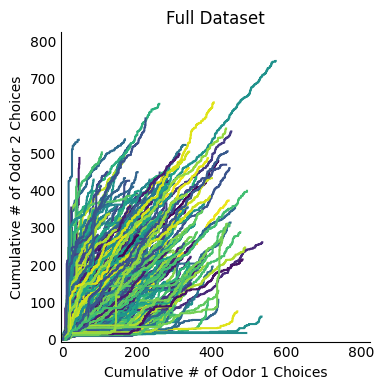

In [10]:
# Fly Behavior

# Full Dataset
fig,ax = plt.subplots(1,1,figsize=(4,4))
for i in range(N):
    ax.plot(np.cumsum(choice_data[i,:]==0), np.cumsum(choice_data[i,:]==1), color=plt.cm.viridis(np.random.rand()))
ax.set_xlabel('Cumulative # of Odor 1 Choices')
ax.set_ylabel('Cumulative # of Odor 2 Choices')
ax.set_xlim([-5,choice_data.shape[1]/1.6])
ax.set_ylim([-5,choice_data.shape[1]/1.6])
ax.set_aspect('equal')
ax.set_title('Full Dataset')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()


Lets also do a plot split by experiment id and lets color by reward rate!

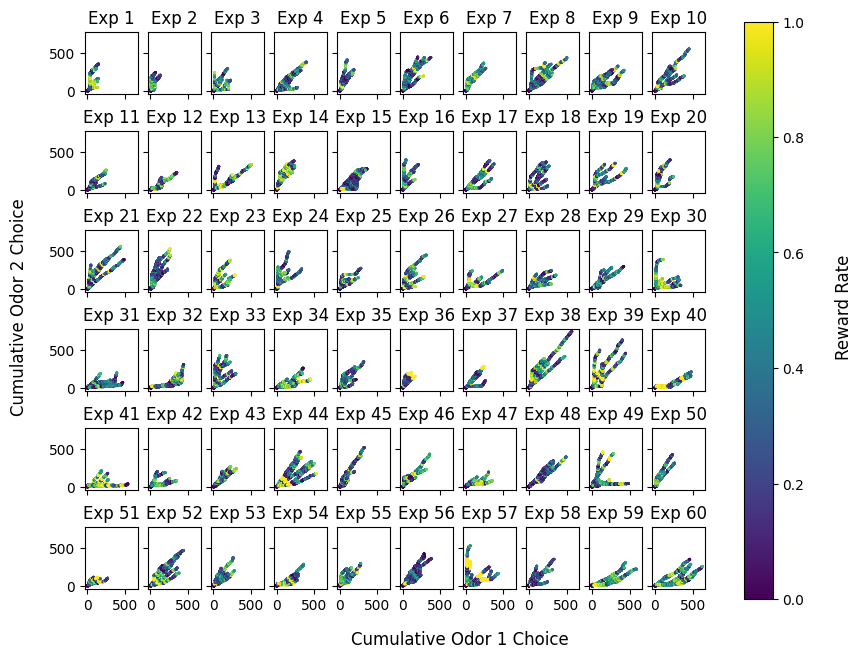

In [11]:
# Individual Experiments

# find most balanced factorization of n_unique_experiments
factors = np.array([i for i in range(1,n_unique_experiments+1) if n_unique_experiments%i==0])
if len(factors) == 2: # if prime number
    factors = np.array([i for i in range(1,(n_unique_experiments+1)+1) if (n_unique_experiments+1)%i==0])
if len(factors) == 4: # if 2*prime number
    factors = np.array([i for i in range(1,(n_unique_experiments+3)+1) if (n_unique_experiments+3)%i==0])

# determine size of figure
if factors.shape[0] % 2 == 0: # if even number of factors
    size_x, size_y = factors[int(factors.shape[0]/2)], factors[int(factors.shape[0]/2)-1]
else:
    size_x, size_y = factors[int(factors.shape[0]/2)], factors[int(factors.shape[0]/2)+1]

# plot the data
fig,ax = plt.subplots(size_y,size_x,figsize=(size_x,size_y*1.25),sharex=True,sharey=True)

for i in range(n_unique_experiments):
    name,rec_name = 'exp{}.csv'.format(i+1),'exp{}_reciprocal.csv'.format(i+1)
    experiments = metadata['Fly Experiment'][metadata['Fly Experiment'] == name]
    reciprocal_experiments = metadata['Fly Experiment'][metadata['Fly Experiment'] == rec_name]
    for j in range(experiments.shape[0]):
        c = choice_data[experiments.index[j],:]
        r = reward_data[experiments.index[j],:]
        # remove values less than 0
        c = c[c>=0]
        r = r[r>=0]
        assert c.shape[0] == r.shape[0], 'Choice and reward data are not the same length'
        c1 = np.cumsum(c==0)
        c2 = np.cumsum(c==1)
        rr = np.convolve(r,np.ones(10)/10,mode='full')
        ax.flatten()[i].scatter(c1,c2,c=rr[:c1.shape[0]],cmap=plt.cm.viridis,s=1)
    for j in range(reciprocal_experiments.shape[0]):
        c = choice_data[reciprocal_experiments.index[j],:]
        r = reward_data[reciprocal_experiments.index[j],:]
        # remove values less than 0
        c = c[c>=0]
        r = r[r>=0]
        assert c.shape[0] == r.shape[0], 'Choice and reward data are not the same length'
        c1 = np.cumsum(c==1)
        c2 = np.cumsum(c==0)
        rr = np.convolve(r,np.ones(10)/10,mode='full')
        ax.flatten()[i].scatter(c1,c2,c=rr[:c1.shape[0]],cmap=plt.cm.viridis,s=1)
    ax.flatten()[i].set_title('Exp {}'.format(i+1))
    ax.flatten()[i].set_aspect('equal')
# remove extra subplots
for i in range(n_unique_experiments,ax.shape[0]*ax.shape[1]):
    fig.delaxes(ax.flatten()[i])
# add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis,norm=plt.Normalize(vmin=0,vmax=1))
sm._A = []
fig.colorbar(sm,ax=ax.ravel().tolist())
# add colorbar label
fig.text(0.875,0.5,'Reward Rate',va='center',rotation='vertical',fontsize=12)
# add labels
fig.text(0.5,0.05,'Cumulative Odor 1 Choice',ha='center',fontsize=12)
fig.text(0.05,0.5,'Cumulative Odor 2 Choice',va='center',rotation='vertical',fontsize=12)
plt.show()